In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import nibabel as nib
import tensorflow as tf
import matplotlib.pyplot as plt
import os

In [3]:
model_path = '/content/drive/MyDrive/4A_GIIADS/Brain_Tumor_Segmentation_Project/u_net_model.hdf5'
flair_path = '/content/drive/MyDrive/4A_GIIADS/Brain_Tumor_Segmentation_Project/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_001/BraTS20_Validation_001_flair.nii'
t1ce_path = '/content/drive/MyDrive/4A_GIIADS/Brain_Tumor_Segmentation_Project/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_001/BraTS20_Validation_001_t1ce.nii'
t2_path = '/content/drive/MyDrive/4A_GIIADS/Brain_Tumor_Segmentation_Project/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_001/BraTS20_Validation_001_t2.nii'

In [4]:
# -----------------------------
# Preprocessing Function
# -----------------------------
def preprocess_image(image_paths):
    modalities = []
    for img_path in image_paths:
        img = nib.load(img_path)
        img_data = img.get_fdata()

        cropped_img = img_data[48:192, 48:192, 5:149]

        mean_val = np.mean(cropped_img)
        std_val = np.std(cropped_img)
        normalized_img = (cropped_img - mean_val) / std_val

        modalities.append(normalized_img)

    stacked_img = np.stack(modalities, axis=3)
    stacked_img = np.expand_dims(stacked_img, axis=0)
    return stacked_img

In [5]:
# -----------------------------
# Visualization Function
# -----------------------------
def visualize_prediction(original_img, prediction, slice_num=None):
    if slice_num is None:
        slice_num = original_img.shape[2] // 2

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(original_img[:, :, slice_num, 1], cmap='gray')
    axs[0].set_title('Original Image (T1CE)')

    pred_argmax = np.argmax(prediction[0], axis=3)
    axs[1].imshow(pred_argmax[:, :, slice_num], cmap='viridis')
    axs[1].set_title('Tumor Segmentation Prediction')

    axs[2].imshow(original_img[:, :, slice_num, 1], cmap='gray')
    mask = pred_argmax[:, :, slice_num]
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.float32)
    colored_mask[mask == 1] = [1, 0, 0]  # Necrotic and non-enhancing tumor core - NCR/NET - Red
    colored_mask[mask == 2] = [0, 1, 0]  # Peritumoral edema - Green
    colored_mask[mask == 3] = [0, 0, 1]  # GD Enhancing Tumor - Blue
    axs[2].imshow(colored_mask, alpha=0.3)
    axs[2].set_title('Prediction Overlay')

    plt.tight_layout()
    plt.show()


In [6]:
def visualize_prediction(original_img, prediction, slice_num=None):
    if slice_num is None:
        slice_num = original_img.shape[2] // 2

    pred_argmax = np.argmax(prediction[0], axis=3)
    mask = pred_argmax[:, :, slice_num]

    # Color mapping (RGBA)
    color_map = {
        0: [0.0, 0.0, 0.0, 0.0],
        1: [1.0, 0.0, 0.0, 0.5],
        2: [0.0, 1.0, 0.0, 0.5],
        3: [0.0, 0.0, 1.0, 0.5],
    }

    # Build color image
    color_mask = np.zeros((*mask.shape, 4))
    for label, color in color_map.items():
        color_mask[mask == label] = color

    # Plot
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    axs[0].imshow(original_img[:, :, slice_num, 1], cmap='gray')
    axs[0].set_title("Original (T1CE)")

    axs[1].imshow(mask, cmap='viridis')
    axs[1].set_title("Prediction (Labels)")

    axs[2].imshow(original_img[:, :, slice_num, 1], cmap='gray')
    axs[2].imshow(color_mask)
    axs[2].set_title("Color Overlay")

    # Legend
    import matplotlib.patches as mpatches
    legend_patches = [
        mpatches.Patch(color='red', label='Necrotic and non-enhancing tumor core - NCR/NET'),
        mpatches.Patch(color='green', label='Peritumoral edema - ED'),
        mpatches.Patch(color='blue', label='GD Enhancing Tumor - ET'),
    ]
    axs[2].legend(handles=legend_patches, loc='lower right')

    plt.tight_layout()
    plt.show()


Model loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


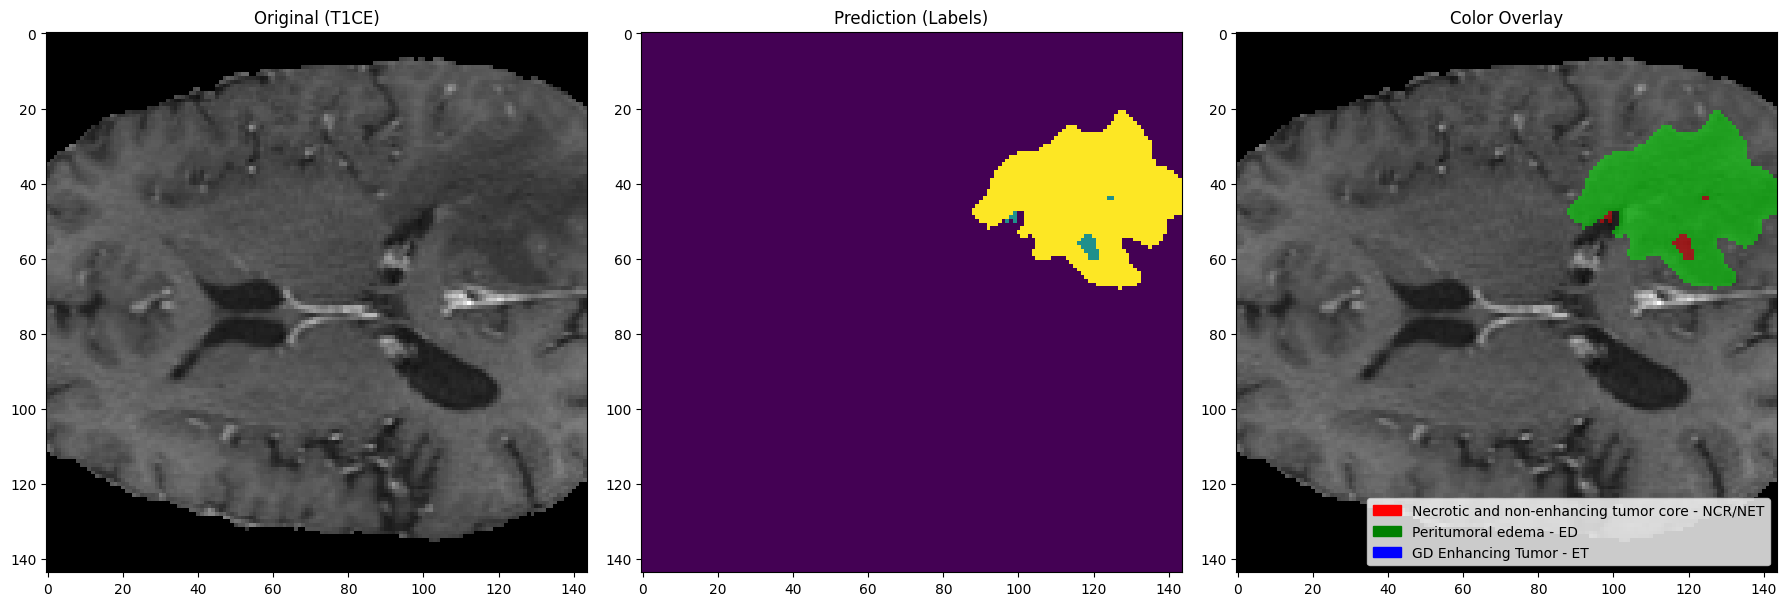


 Prediction Statistics:
Background: 2872211 voxels
Necrotic and non-enhancing tumor core - NCR/NET: 1850 voxels
Peritumoral edema - ED: 94740 voxels
GD Enhancing Tumor - ET: 17183 voxels


In [7]:
# -----------------------------
# Load Model
# -----------------------------
try:
    model = tf.keras.models.load_model(model_path, compile=False)
    print("Model loaded successfully.")
except Exception as e:
    raise RuntimeError(f"Error loading model: {e}")

# -----------------------------
# Predict and Visualize
# -----------------------------
try:
    preprocessed_img = preprocess_image([flair_path, t1ce_path, t2_path])
    prediction = model.predict(preprocessed_img)

    visualize_prediction(preprocessed_img[0], prediction)

    pred_argmax = np.argmax(prediction[0], axis=3)
    unique, counts = np.unique(pred_argmax, return_counts=True)
    tumor_classes = ['Background', 'Necrotic and non-enhancing tumor core - NCR/NET','Peritumoral edema - ED', 'GD Enhancing Tumor - ET']

    print("\n Prediction Statistics:")
    for cls, count in zip(unique, counts):
        label = tumor_classes[cls] if cls < len(tumor_classes) else f"Class {cls}"
        print(f"{label}: {count} voxels")

except Exception as e:
    raise RuntimeError(f"Prediction failed: {e}")


In [8]:
model_path = '/content/drive/MyDrive/4A_GIIADS/Brain_Tumor_Segmentation_Project/u_net_model.hdf5'
flair_path = '/content/drive/MyDrive/4A_GIIADS/Brain_Tumor_Segmentation_Project/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_002/BraTS20_Validation_002_flair.nii'
t1ce_path = '/content/drive/MyDrive/4A_GIIADS/Brain_Tumor_Segmentation_Project/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_002/BraTS20_Validation_002_t1ce.nii'
t2_path = '/content/drive/MyDrive/4A_GIIADS/Brain_Tumor_Segmentation_Project/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData/BraTS20_Validation_002/BraTS20_Validation_002_t2.nii'

1/1 ━━━━━━━━━━━━━━━━━━━━ 17s 17s/step


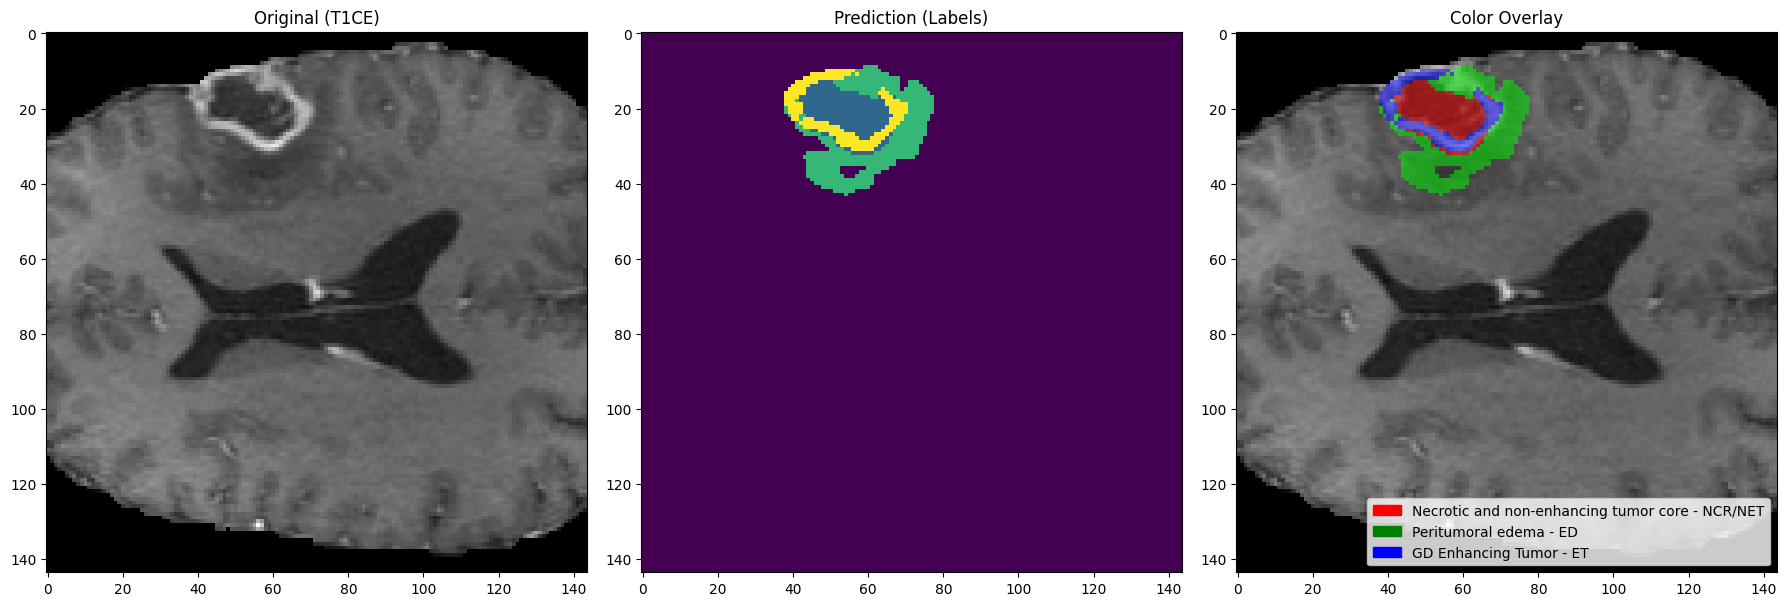


 Prediction Statistics:
Background: 2960160 voxels
Necrotic and non-enhancing tumor core - NCR/NET: 3640 voxels
Peritumoral edema - ED: 16837 voxels
GD Enhancing Tumor - ET: 5347 voxels


In [9]:
try:
    preprocessed_img = preprocess_image([flair_path, t1ce_path, t2_path])
    prediction = model.predict(preprocessed_img)

    visualize_prediction(preprocessed_img[0], prediction)

    pred_argmax = np.argmax(prediction[0], axis=3)
    unique, counts = np.unique(pred_argmax, return_counts=True)
    tumor_classes = ['Background', 'Necrotic and non-enhancing tumor core - NCR/NET','Peritumoral edema - ED', 'GD Enhancing Tumor - ET']

    print("\n Prediction Statistics:")
    for cls, count in zip(unique, counts):
        label = tumor_classes[cls] if cls < len(tumor_classes) else f"Class {cls}"
        print(f"{label}: {count} voxels")

except Exception as e:
    raise RuntimeError(f"Prediction failed: {e}")